In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-product-reviews/ratings_Electronics (1).csv


# Recommendation System

**What recommeder system can solve ?**

* It can help the user to find the right product.
* It can increase the user engagement. For example, there's 40% more click on the google news due to recommendation.
* It helps the item providers to deliver the items to the right user.In Amazon , 35 % products get sold due to recommendation.
* It helps to make the contents more personalized.

## Types of Recommendation System

1. Popularity Based Recommendation
2. Classification model based
3. Content Recommendation System
4. Collaborative Filtering: It is based on assumption that people like things similar to other things they like, and things that are liked by other people with similar taste.
5. Hybrid Approaches
6. Association Rule Minning

In [2]:
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
# from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [3]:
electronics_df=pd.read_csv("/kaggle/input/amazon-product-reviews/ratings_Electronics (1).csv",
                             names=['userId', 'productId','Rating','timestamp'])

In [4]:
electronics_df.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [5]:
product_id_avg = dict(electronics_df.groupby(['productId']).Rating.mean())

In [6]:
k = 0
for i in product_id_avg.keys():
    print(i,":",product_id_avg[i])
    k+=1
    if k>5:
        break

0132793040 : 5.0
0321732944 : 5.0
0439886341 : 1.6666666666666667
0511189877 : 4.5
0528881469 : 2.8518518518518516
0558835155 : 3.0


In [7]:
#Shape of the data
electronics_df.shape

(7824482, 4)

In [8]:
electronics_df.dtypes

userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object

In [9]:
electronics_df.describe()

,Rating,timestamp
count,7.824482e+06,7.824482e+06
mean,4.012337e+00,1.338178e+09
std,1.380910e+00,6.900426e+07
min,1.000000e+00,9.127296e+08
25%,3.000000e+00,1.315354e+09
50%,5.000000e+00,1.361059e+09
75%,5.000000e+00,1.386115e+09
max,5.000000e+00,1.406074e+09


In [10]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_df.Rating.min()))
print('Maximum rating is: %d' %(electronics_df.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


<AxesSubplot:xlabel='Rating', ylabel='Count'>

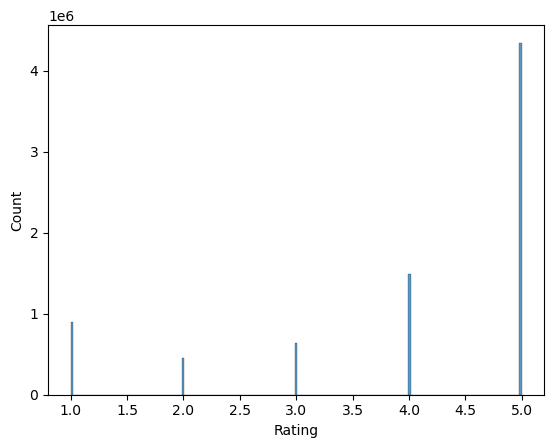

In [11]:
# Rating Distribution
sns.histplot(electronics_df['Rating'])

In [12]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",electronics_df.shape[0])
print("Total No of Users   :", len(np.unique(electronics_df.userId)))
print("Total No of products  :", len(np.unique(electronics_df.productId)))

Total data 
--------------------------------------------------

Total no of ratings : 7824482
Total No of Users   : 4201696
Total No of products  : 476002


In [13]:
#Dropping the Timestamp column
electronics_df.drop(['timestamp'], axis=1,inplace=True)

In [14]:
no_of_rated_products_per_user = electronics_df.groupby(by='userId')['Rating'].count().sort_values(ascending=False)
no_of_rated_products_per_user.head()

userId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
Name: Rating, dtype: int64

In [15]:
no_of_rated_products_per_user.describe()

count    4.201696e+06
mean     1.862220e+00
std      2.885110e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      5.200000e+02
Name: Rating, dtype: float64

In [16]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

<Figure size 1000x1000 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

<AxesSubplot:title={'center':'Quantiles and their Values'}>

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

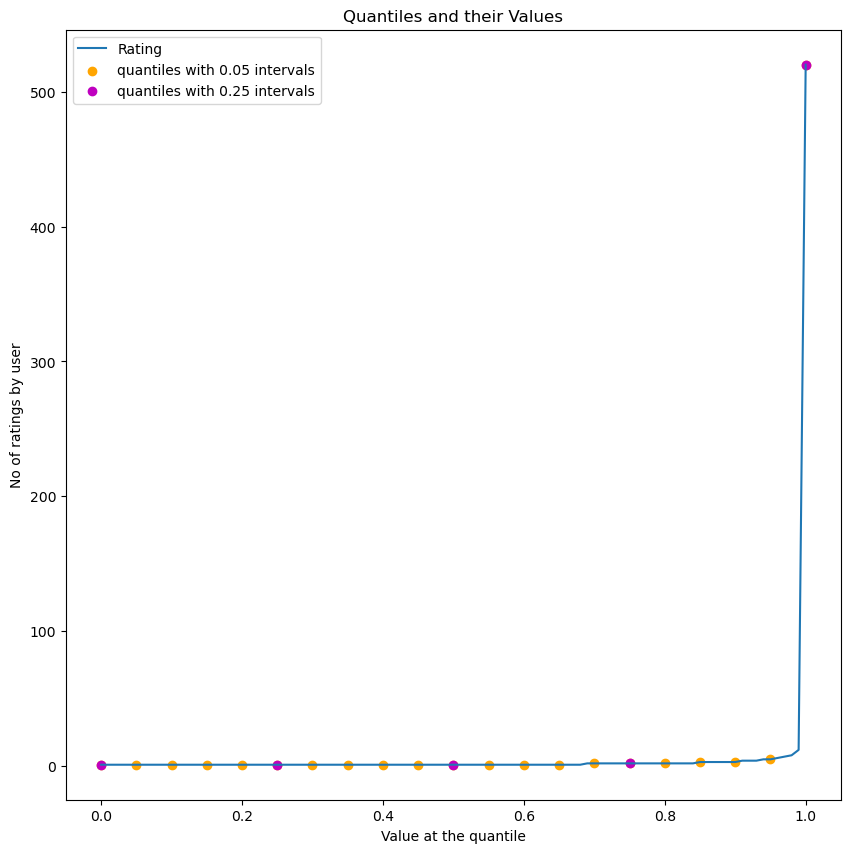

In [17]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [18]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )


 No of rated product more than 50 per user : 1540



## Popularity Based Recommendation

In [19]:
sorted_product = pd.DataFrame(product_id_avg,index = ['Rating']).T#.sort_values()

sorted_product.head()

,Rating
0132793040,5.000000
0321732944,5.000000
0439886341,1.666667
0511189877,4.500000
0528881469,2.851852


In [20]:
sorted_product = sorted_product.sort_values(by = 'Rating',ascending = False)
sorted_product.head()

,Rating
0132793040,5.0
B004SGH244,5.0
B004SQBRRM,5.0
B004SQC6O0,5.0
B004SQE6YI,5.0


In [21]:
sorted_product['rating_counts'] = pd.DataFrame(electronics_df.groupby('productId')['Rating'].count())

In [22]:
sorted_product['rating_counts'].max()

18244

<Figure size 800x600 with 0 Axes>

<AxesSubplot:>

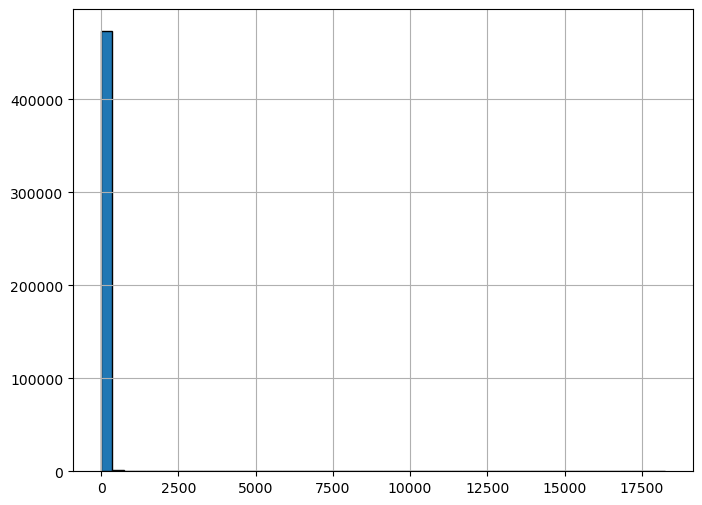

In [23]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sorted_product['rating_counts'].hist(bins=50)

<Figure size 800x600 with 0 Axes>

<AxesSubplot:>

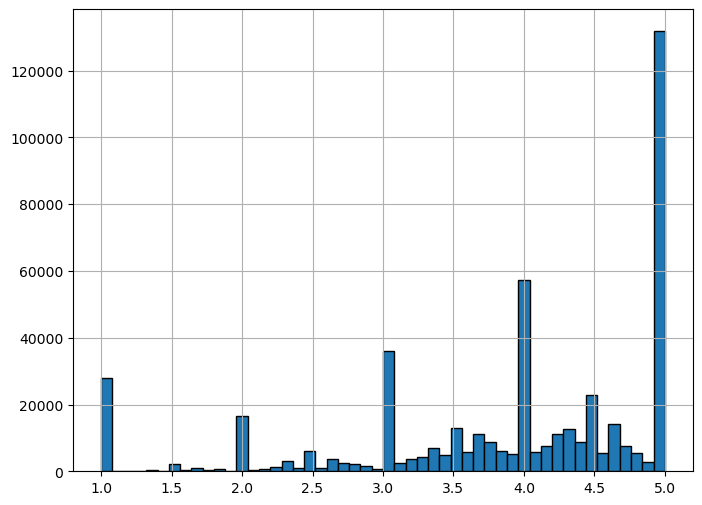

In [24]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sorted_product['Rating'].hist(bins=50)

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

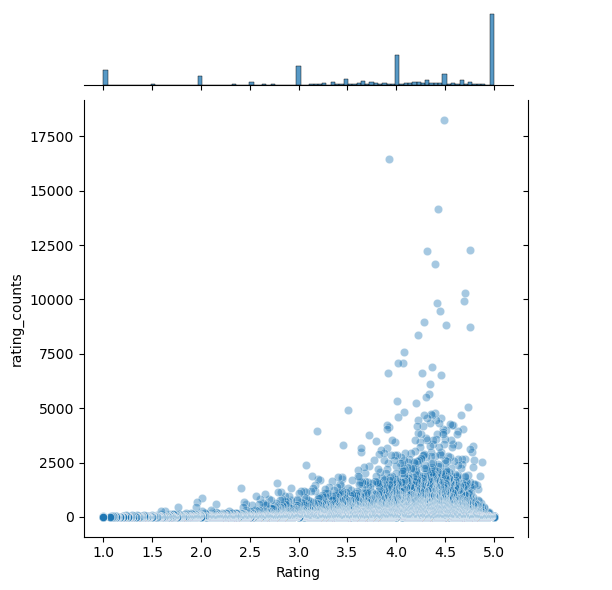

In [25]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=sorted_product, alpha=0.4)
plt.show()

## Collaborative Filtering

In [26]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [33]:
sorted_product = sorted_product.sort_values(by = ['Rating','rating_counts'],ascending = False)
sorted_product.head()

,Rating,rating_counts
B008I64AQ8,5.0,45
B00GQDCMVA,5.0,41
B007WMOCW6,5.0,38
B00592002W,5.0,36
B002T3JN0Y,5.0,36


In [50]:
sp.head()

,index,Rating,rating_counts
0,B008I64AQ8,5.0,45
1,B00GQDCMVA,5.0,41
2,B007WMOCW6,5.0,38
3,B00592002W,5.0,36
4,B002T3JN0Y,5.0,36


In [40]:
reader = Reader(rating_scale=(1, 5))
sp = sorted_product.reset_index()
data = Dataset.load_from_df(sp,reader)

In [41]:
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [42]:
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [43]:
test_pred = algo.test(testset)
test_pred

[Prediction(uid='B00006SNZN', iid=4.3561643835616435, r_ui=73.0, est=5, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='B004QY2H2K', iid=3.0, r_ui=4.0, est=5, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='B00BG4NJKM', iid=4.666666666666667, r_ui=6.0, est=5, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='B006WTMU4C', iid=2.0, r_ui=1.0, est=5, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='B001F0RNI6', iid=5.0, r_ui=2.0, est=5, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='B001PIF3KS', iid=3.5, r_ui=6.0, est=5, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='B004NBZ8V8', iid=4.166666666666667, r_ui=6.0, est=5, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='B0068E6Q

In [45]:
print("Item-based Model : Test Set")
accuracy.mae(test_pred, verbose=True)

Item-based Model : Test Set
MAE:  15.9996


15.99955182386678

In [59]:
new_df1=electronics_df.head(1000)
ratings_matrix = new_df1.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix.T.head()

userId,A030530627MK66BD8V4LN,A1038957GWRBP375RU5T,A106YUCY4SVX1D,A1079KKA0AXSL3,A107S4MT25VXQ5,A108UXJTIV8XXY,A10MC5C359B1T7,A10MF6OJK61N22,A10S9NK38WEQ65,A10TQRXANRYQ6D,...,AYZ54MQJUM3NV,AZ3DVRQOQMC59,AZ6SUJ5T0KBE5,AZFF4CX9MQ4AE,AZM8PD2KBVXN5,AZO3DZAJ8S0D9,AZPT44204EODM,AZQZ3STMCBG5H,AZTC7YC8PKG39,AZYNQZ94U6VDB
productId,,,,,,,,,,,,,,,,,,,,,
0132793040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0321732944,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0439886341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0511189877,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
0528881469,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
ratings_matrix = ratings_matrix.T

In [63]:
ratings_matrix.shape

(39, 1000)

In [65]:
#Decomposing the Matrix
X = ratings_matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(39, 10)

In [69]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(39, 39)

<Figure size 1000x1000 with 0 Axes>

Text(0.5, 1.0, ' Correlation plot (Pearson)')

<AxesSubplot:title={'center':' Correlation plot (Pearson)'}>

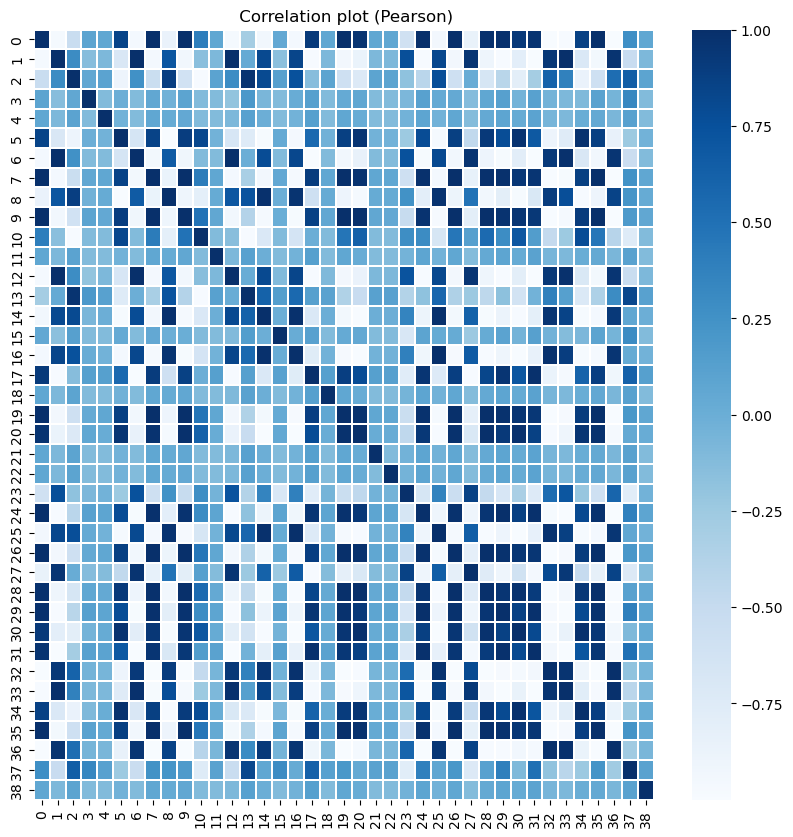

In [70]:
plt.figure(figsize = (10,10))
plt.title(' Correlation plot (Pearson)')
sns.heatmap(correlation_matrix,linewidths=.1,cmap="Blues")
plt.show()

In [80]:
X.index[1]

'0321732944'

In [81]:
i = '0321732944'

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

1

In [82]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(39,)

In [83]:
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend

['059400232X',
 '0594017343',
 '0594033934',
 '0594287995',
 '0594450209',
 '0594482127',
 '0594514681',
 '0594549507',
 '0879393742',
 '089933623X',
 '0970407998']

Here are the top 10 products to be displayed by the recommendation system to the above customer based on the purchase history of other customers in the website.